# 1_mortality_prediction

In [1]:
#Packages
import numpy as np
import pandas as pd
import sklearn as skl
from scipy.stats import pearsonr
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsRegressor


import matplotlib.pyplot as plt

In [2]:
censoc_path = os.getcwd() + '/data/censoc_numident_v2_linked.csv'
censoc_1 = pd.read_csv(censoc_path)

/opt/homebrew/Caskroom/miniforge/base/envs/tf_env/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (162) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
censoc_1

,YEAR,SAMPLE,SERIAL,NUMPREC,SUBSAMP,HHWT,NUMPERHH,HHTYPE,SLPERNUM,CPI99,...,race_last_cmonth,bpl,zip_residence,age_first_application,link_abe_exact_conservative,weight,weight_conservative,socstate,bpl_string,socstate_string
0,1940,194002,7,3,6,1,3,3,0,11.986,...,11.0,100,366082851,19.0,1,2.688433,3.537075,100.0,Alabama,Alabama
1,1940,194002,19,2,73,1,2,3,0,11.986,...,8.0,100,726240000,21.0,0,5.136342,NaN,800.0,Alabama,Colorado
2,1940,194002,19,2,73,1,2,3,0,11.986,...,2.0,100,352446732,16.0,0,2.506503,NaN,100.0,Alabama,Alabama
3,1940,194002,23,6,24,1,6,1,0,11.986,...,NaN,100,774800049,NaN,1,2.762535,3.643916,100.0,Alabama,Alabama
4,1940,194002,30,3,72,1,3,3,1,11.986,...,11.0,100,360251526,17.0,1,2.765125,3.615807,100.0,Alabama,Alabama
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7890986,1940,194002,37780601,1,26,1,1,6,0,11.986,...,10.0,3000,599373265,29.0,1,8.483776,13.203739,4100.0,Montana,Oregon
7890987,1940,194002,37780623,1,24,1,1,4,0,11.986,...,5.0,2700,XX7970000,24.0,1,4.865539,6.202986,3000.0,Minnesota,Montana
7890988,1940,194002,37780638,4,33,1,4,1,4,11.986,...,2.0,5300,953570254,48.0,1,13.021048,16.475612,600.0,Washington,California
7890989,1940,194002,37780655,1,89,1,1,4,0,11.986,...,2.0,5600,952400597,19.0,0,2.912121,NaN,600.0,Wyoming,California


In [4]:
# Keep only 1910 Birth Cohort
censoc_2 = censoc_1[censoc_1['byear'] == 1910]

# Keep only ABE conservative match
censoc_3 = censoc_2[censoc_2['link_abe_exact_conservative'] == 1]


In [5]:
censoc_4 = (censoc_3.assign(EDUCD = np.where((censoc_3.EDUCD == 999), np.nan, censoc_3.EDUCD))
                    .assign(INCWAGE = np.where((censoc_3.INCWAGE >= 999998), np.nan, censoc_3.INCWAGE))
                    .assign(RENT = np.where((censoc_3.RENT >= 9998), np.nan, censoc_3.RENT)))
censoc_4['EDUCD'].value_counts().sort_index()

0.0       167
2.0       527
14.0      159
15.0      380
16.0      607
17.0     1121
22.0     1193
23.0     1994
25.0     2772
26.0     8796
30.0     3100
40.0     3660
50.0     2233
60.0     9797
70.0     1189
80.0     1627
90.0      804
100.0    2607
110.0     927
111.0      63
112.0      47
113.0      62
Name: EDUCD, dtype: int64

In [6]:
print('RENT -- before:', censoc_3['RENT'].mean(), '; after:', censoc_4['RENT'].mean())

RENT -- before: 273.68984700973573 ; after: 33.390685699836794


In [7]:
vars_to_keep = ['EDUCD', 'SEI', 'INCWAGE', 'OCCSCORE', 'PERNUM', 'NUMPERHH', 'SEX', 'RACE', 'METRO',
                'PRESGL', 'MARST', 'CITYPOP', 'NSIBS', 'RENT', 'HISPAN', 'CLASSWKR', 'MOMLOC', 'MIGRATE5',
                'LABFORCE', 'NFAMS', 'URBAN', 'FARM', 'OWNERSHP', 'PRESGL', 'NCOUPLES', 'NMOTHERS',
                'NFATHERS', 'MULTGEND', 'WKSWORK1', 'WKSWORK2', 'HRSWORK1', 'HRSWORK2', 'MARRNO',
                'AGEMARR', 'CHBORN', 'death_age']

In [8]:
censoc_4['NMOTHERS'].value_counts().sort_index()

0    11712
1    29317
2     3306
3      219
4       15
5        8
6        1
Name: NMOTHERS, dtype: int64

In [9]:
censoc_5 = censoc_4.filter(vars_to_keep)
censoc_5.head(3)

,EDUCD,SEI,INCWAGE,OCCSCORE,PERNUM,NUMPERHH,SEX,RACE,METRO,PRESGL,...,NFATHERS,MULTGEND,WKSWORK1,WKSWORK2,HRSWORK1,HRSWORK2,MARRNO,AGEMARR,CHBORN,death_age
530,17.0,6,60.0,9,3,5,2,2,1,18.4,...,1,22,36,3,40,5,0,0,0,83
656,80.0,72,600.0,27,4,4,2,1,1,59.6,...,1,22,52,6,30,3,0,0,0,85
680,60.0,0,0.0,0,2,2,2,1,1,0.0,...,0,10,0,0,0,0,0,0,0,85


### Imputation of Missing Data

In [10]:
print(censoc_5.isnull().sum())

EDUCD         746
SEI             0
INCWAGE      3744
OCCSCORE        0
PERNUM          0
NUMPERHH        0
SEX             0
RACE            0
METRO           0
PRESGL          0
MARST           0
CITYPOP         0
NSIBS           0
RENT         1075
HISPAN          0
CLASSWKR        0
MOMLOC          0
MIGRATE5        0
LABFORCE        0
NFAMS           0
URBAN           0
FARM            0
OWNERSHP        0
PRESGL          0
NCOUPLES        0
NMOTHERS        0
NFATHERS        0
MULTGEND        0
WKSWORK1        0
WKSWORK2        0
HRSWORK1        0
HRSWORK2        0
MARRNO          0
AGEMARR         0
CHBORN          0
death_age       0
dtype: int64


In [11]:
imputer = KNNImputer(n_neighbors=3)
censoc_6 = imputer.fit_transform(censoc_5)
censoc_6 = pd.DataFrame(censoc_6, columns = censoc_5.columns)

censoc_6.head()

,EDUCD,SEI,INCWAGE,OCCSCORE,PERNUM,NUMPERHH,SEX,RACE,METRO,PRESGL,...,NFATHERS,MULTGEND,WKSWORK1,WKSWORK2,HRSWORK1,HRSWORK2,MARRNO,AGEMARR,CHBORN,death_age
0,17.0,6.0,60.000000,9.0,3.0,5.0,2.0,2.0,1.0,18.4,...,1.0,22.0,36.0,3.0,40.0,5.0,0.0,0.0,0.0,83.0
1,80.0,72.0,600.000000,27.0,4.0,4.0,2.0,1.0,1.0,59.6,...,1.0,22.0,52.0,6.0,30.0,3.0,0.0,0.0,0.0,85.0
2,60.0,0.0,0.000000,0.0,2.0,2.0,2.0,1.0,1.0,0.0,...,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,85.0
3,22.0,6.0,216.666667,9.0,4.0,4.0,1.0,1.0,1.0,18.4,...,1.0,22.0,50.0,6.0,60.0,8.0,0.0,0.0,0.0,80.0
4,26.0,0.0,0.000000,0.0,2.0,9.0,2.0,2.0,1.0,0.0,...,1.0,21.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,86.0


In [12]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()

censoc_7 = min_max_scaler.fit_transform(censoc_6)
censoc_7 = pd.DataFrame(censoc_7, columns = censoc_6.columns)

censoc_7.head()

,EDUCD,SEI,INCWAGE,OCCSCORE,PERNUM,NUMPERHH,SEX,RACE,METRO,PRESGL,...,NFATHERS,MULTGEND,WKSWORK1,WKSWORK2,HRSWORK1,HRSWORK2,MARRNO,AGEMARR,CHBORN,death_age
0,0.150442,0.0625,0.005405,0.1125,0.037736,0.000471,1.0,0.2,0.0,0.225767,...,0.2,0.68750,0.692308,0.5,0.408163,0.625,0.0,0.0,0.0,0.333333
1,0.707965,0.7500,0.054054,0.3375,0.056604,0.000353,1.0,0.0,0.0,0.731288,...,0.2,0.68750,1.000000,1.0,0.306122,0.375,0.0,0.0,0.0,0.444444
2,0.530973,0.0000,0.000000,0.0000,0.018868,0.000118,1.0,0.0,0.0,0.000000,...,0.0,0.31250,0.000000,0.0,0.000000,0.000,0.0,0.0,0.0,0.444444
3,0.194690,0.0625,0.019520,0.1125,0.056604,0.000353,0.0,0.0,0.0,0.225767,...,0.2,0.68750,0.961538,1.0,0.612245,1.000,0.0,0.0,0.0,0.166667
4,0.230088,0.0000,0.000000,0.0000,0.018868,0.000942,1.0,0.2,0.0,0.000000,...,0.2,0.65625,0.000000,0.0,0.000000,0.000,0.0,0.0,0.0,0.500000


### Modeling

In [13]:
y = censoc_6[['death_age']]
X = censoc_6.drop(columns = ['death_age'])

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.25, random_state=2232)

In [14]:

def get_stats(model_obj):
    y_pred = model_obj.predict(X_test)
    mse = mean_squared_error(y_test,y_pred)
    corr, _ = pearsonr(y_test['death_age'],y_pred)
    mae = mean_absolute_error(y_test['death_age'],y_pred)
    # print(model_obj)
    # print('MSE: %.3f' % mse)
    # print('MAE: %.3f' % mae)
    # print('R: %.3f' % corr)

    data = [[str(model_obj), mse, corr, mae]]
    df = pd.DataFrame(data, columns = ['model', 'mse', 'corr', 'mae'])

    return df

#### Gradient Boosting

In [15]:
gbr = GradientBoostingRegressor(n_estimators=35, 
    max_depth=5, 
    learning_rate=0.01, 
    min_samples_split=3)

gbr = GradientBoostingRegressor()
 
gbr.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/tf_env/lib/python3.9/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GradientBoostingRegressor()

#### Gradient Boosting Light

In [16]:
hgbr = HistGradientBoostingRegressor()
hgbr.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/tf_env/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


HistGradientBoostingRegressor()

#### ElasticNet

In [17]:
enet = ElasticNet()
enet.fit(X_train, y_train)

ElasticNet()

#### LASSO 

In [18]:
regLasso = Lasso(alpha=1)
regLasso.fit(X_train, y_train)

Lasso(alpha=1)

In [19]:
br = BayesianRidge()
br.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/tf_env/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


BayesianRidge()

#### Linear Regression

In [20]:

lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

#### Linear Discriminant Analysis

In [21]:
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

/opt/homebrew/Caskroom/miniforge/base/envs/tf_env/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LinearDiscriminantAnalysis()

#### K Nearest Neighbors

In [22]:
kn = KNeighborsRegressor()
kn.fit(X_train, y_train)

KNeighborsRegressor()

#### Random Forest

In [23]:
rf = RandomForestRegressor()
rf.fit(X_train, y_train) 

/var/folders/f0/lv4rn9cj3773mrlxlb1vmf380000gn/T/ipykernel_71032/2623689323.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train, y_train)


RandomForestRegressor()

### Get Model Performance Statistics

In [54]:
df = (get_stats(lm)
      .append(get_stats(gbr))
      .append(get_stats(lda))
      .append(get_stats(regLasso))
      .append(get_stats(enet))
      .append(get_stats(br))
      .append(get_stats(kn))
      .append(get_stats(rf))
      .append(get_stats(hgbr)))
    
df[['corr']] = df[['corr']].astype(np.float16)

df

,model,mse,corr,mae
0,LinearRegression(),22.248770,0.122742,3.999538
0,GradientBoostingRegressor(),22.267188,0.119690,4.001980
0,LinearDiscriminantAnalysis(),27.833378,0.086426,4.326694
0,Lasso(alpha=1),22.475836,0.071594,4.026276
0,ElasticNet(),22.452464,0.078308,4.023741
0,BayesianRidge(),22.257424,0.121216,4.001478
0,KNeighborsRegressor(),26.666749,0.027740,4.296510
0,RandomForestRegressor(),23.503147,0.073914,4.081835
0,HistGradientBoostingRegressor(),22.288522,0.116028,4.004647


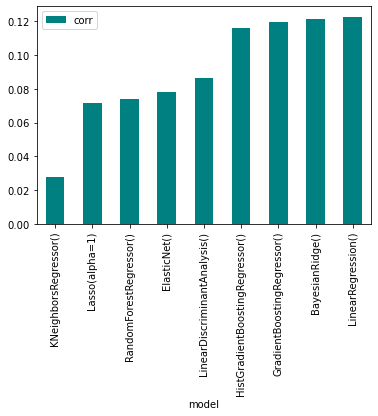

In [64]:
import matplotlib.pyplot as plt
df.sort_values('corr', ascending = True).plot(kind='bar',x='model',y='corr', color='teal')
plt.show()

In [59]:
import statsmodels.api as sm

mod = sm.OLS(y_train, X_train)

res = mod.fit()

print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:              death_age   R-squared (uncentered):                   0.992
Model:                            OLS   Adj. R-squared (uncentered):              0.992
Method:                 Least Squares   F-statistic:                          1.180e+05
Date:                Sat, 23 Apr 2022   Prob (F-statistic):                        0.00
Time:                        10:37:07   Log-Likelihood:                     -1.1618e+05
No. Observations:               33433   AIC:                                  2.324e+05
Df Residuals:                   33399   BIC:                                  2.327e+05
Df Model:                          34                                                  
Covariance Type:            nonrobust                                                  
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------